In [618]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import KFold

from collections import Counter

# 导入筛选好的股票数据和因子数据（6 factors）

### 数据获取
1.从 joinquant 通过get_price()函数获得HS300的所有股票数据，通过get_factor_values()函数获得六个因子的数据并下载到本地，分别是：['momentum','EMA5','EMAC10','MAC5','MAC10', 'book_to_price_ratio']

2.下载 HS300 的指数作为基准

3.过滤掉180天内停牌100天的股票，过滤ST股，过滤300天未上市的股票。

In [537]:
HS300_index = pd.read_csv('data/HS300_index.csv', index_col=0)
HS300_filtered = pd.read_csv('data/HS300_filtered.csv', index_col=0)
df_mom = pd.read_csv('data/momentum.csv', index_col=0)
df_EMA5 = pd.read_csv('data/EMA5.csv', index_col=0)
df_EMAC10 = pd.read_csv('data/EMAC10.csv', index_col=0)
df_MAC5 = pd.read_csv('data/MAC5.csv', index_col=0)
df_MAC10 = pd.read_csv('data/MAC10.csv', index_col=0)
df_PB = pd.read_csv('data/book_to_price_ratio.csv', index_col=0)

 ### 数据预处理

In [538]:
#去极值
def three_sigma(series,n):
    mean = series.mean()
    std = series.std()
    max_range = mean + n * std
    min_range = mean - n * std
    return np.clip(series, min_range, max_range)

对因子用3-sigma原则进行去极值，然后利用进行0-1标准化。

In [539]:
df_mom = df_mom.apply(lambda x: three_sigma(x,3), axis = 0)
df_EMA5 = df_EMA5.apply(lambda x: three_sigma(x,3), axis = 0)
df_EMAC10 = df_EMAC10.apply(lambda x: three_sigma(x,3), axis = 0)
df_MAC5 = df_MAC5.apply(lambda x: three_sigma(x,3), axis = 0)
df_MAC10 = df_MAC10.apply(lambda x: three_sigma(x,3), axis = 0)
df_PB = df_PB.apply(lambda x: three_sigma(x,3), axis = 0)

In [540]:
#标准化
df_mom = df_mom.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)), axis = 0)
df_EMA5 = df_EMA5.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)), axis = 0)
df_EMAC10 = df_EMAC10.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)), axis = 0)
df_MAC5 = df_MAC5.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)), axis = 0)
df_MAC10 = df_MAC10.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)), axis = 0)
df_PB = df_PB.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)), axis = 0)

对因子用0填补空值

In [541]:
#补空值
df_mom = df_mom.fillna(0)
df_EMA5 = df_EMA5.fillna(0)
df_EMAC10 = df_EMAC10.fillna(0)
df_MAC5 = df_MAC5.fillna(0)
df_MAC10 = df_MAC10.fillna(0)
df_PB = df_PB.fillna(0)

将因子按名称和数据框写入在字典中便于未来调用，同时将日频因子数据用resample方法变为周频因子数据。

In [203]:
import copy

f_list = [df_mom, df_EMA5, df_EMAC10, df_MAC5, df_MAC10, df_PB]
f_name = ['momentum','EMA5','EMAC10','MAC5','MAC10', 'book_to_price_ratio']
factors = {}
for i in range(len(f_list)):
    factors.update({f_name[i]:f_list[i]})

factors_weekly = {}
for i in range(len(f_name)):
    f = copy.deepcopy(f_list[i])
    f.index = pd.to_datetime(f.index)
    f_weekly = f.resample('1W').last().fillna(0)
    factors_weekly.update({f_name[i]:f_weekly})



In [614]:
HS300_filtered

,000001.XSHE,000063.XSHE,000069.XSHE,000157.XSHE,000166.XSHE,000333.XSHE,000338.XSHE,000425.XSHE,000568.XSHE,000596.XSHE,...,603160.XSHG,603259.XSHG,603260.XSHG,603288.XSHG,603369.XSHG,603658.XSHG,603799.XSHG,603833.XSHG,603899.XSHG,603993.XSHG
2010-01-04,7.67,19.58,5.70,5.85,NaN,NaN,5.23,5.46,26.50,15.46,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,7.54,19.95,5.46,5.75,NaN,NaN,5.12,5.43,26.35,15.57,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,7.41,19.54,5.51,5.98,NaN,NaN,5.58,5.46,25.97,16.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,7.33,18.63,5.43,5.81,NaN,NaN,5.57,5.33,25.44,15.60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,7.31,18.71,5.49,5.71,NaN,NaN,5.66,5.18,25.86,15.70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-13,16.06,35.74,7.05,8.59,5.51,75.89,15.86,5.92,152.45,225.61,...,172.63,109.00,29.63,172.63,48.55,168.90,36.92,116.89,74.00,3.95
2020-10-14,16.03,35.30,6.86,8.74,5.44,75.25,16.07,5.86,150.70,222.99,...,168.66,108.53,29.98,171.49,48.35,171.50,37.27,117.38,76.29,3.89
2020-10-15,16.56,34.76,6.86,8.63,5.44,76.10,15.94,5.79,151.70,219.00,...,167.20,109.31,29.75,171.00,49.26,171.13,37.08,117.75,76.63,3.89
2020-10-16,17.10,34.47,6.83,8.87,5.45,74.80,16.09,5.77,149.88,210.70,...,166.20,108.41,29.44,168.35,48.84,170.34,35.98,118.96,77.34,3.90


将数据框的time index变成datetime形式

In [545]:
HS300_filtered.index = pd.to_datetime(HS300_filtered.index)
HS300_index.index = pd.to_datetime(HS300_index.index)

将日频的股价数据和指数数据都转化成周频

In [546]:
HS300_weekly = HS300_filtered.resample('1W').last()
HS300indexweekly = HS300_index.resample('1W').last()

获得股价和指数的周收益率，缺失值用0填补

In [548]:
HSreturns = HS300_weekly.pct_change().fillna(0)
HSIreturns = HS300indexweekly.pct_change().fillna(0) 
HSIreturns

,000300.XSHG
2010-01-10,0.000000
2010-01-17,0.000750
2010-01-24,-0.033462
2010-01-31,-0.048137
2010-02-07,-0.015939
...,...
2020-09-27,-0.035268
2020-10-04,0.003803
2020-10-11,0.020434
2020-10-18,0.023614


过去两年中，每周涨幅排名前30%（以rate作为变量）的股票标记为+1，后30%的股票标记为-1

In [619]:
#c = c1.loc[(slice(None),'close'),].T
T, N = HSreturns.shape
rate = 0.3 #30%
select_ratio = 0.1
y_labels = pd.DataFrame(np.zeros((T, N)),index=HSreturns.index,columns=stocks)

In [620]:
#labeling
for t in range(T):
    x = HSreturns.iloc[t,]
    x1 = x.argsort(x)
    low_stocks = x[x1][:int(N*rate)].index.tolist()
    high_stocks = x[x1][int(N*(1-rate)):].index.tolist()
    y_labels.iloc[t][low_stocks] = -1
    y_labels.iloc[t][high_stocks] = 1

为了做预测，将数据下移一周从而在训练集里这个label是预测出来的东西

In [560]:
y_pred_labels = y_labels.shift(1).fillna(0) #this is the label for machine learning
y_pred_labels

设定各种窗口长度：
1.train_length 表示训练集的时间长度，表示过去两年的所有股票机器因子数据作为训练集
2.test_length 根据训练出来的模型在这个窗口里进行选股，时长半年
3.change_position_length 表示调仓时间，每隔四周调仓一次，调仓包括选股和计算权重
4.mean_variance_length 表示用均值方差计算均值向量和协方差矩阵所需要的收益率数据的时间长度

In [562]:
#设定窗口长度
train_length = 104 #训练集：2年
test_length = 26 #测试集：半年
change_position_length = 4 #调仓频率：月度
mean_variance_length = 10 #均值方差窗口：10周


### 机器学习模型
clf_list 是几个模型的组合，进而可以用votingclassifier对他们进行投票，输出就是根据输入数据而训练出的模型对象。

In [628]:
#机器学习方法
#input: y_pred_labels (df),  X_df (df)
clf_list = [('decision tree', DecisionTreeClassifier()),
            #('logistic regression', LogisticRegression()),
            ('knn', KNeighborsClassifier()),
            ('naive bayes', GaussianNB()),
            ('Adaboost', AdaBoostClassifier()),
            ('GradientBoosting', GradientBoostingClassifier())]

#gridsearch = False
#method = 'naive bayes classifier' 
#method = 'logistic regression' 
#method = 'knn'
#method = 'decision tree'
#method = 'ensemble'
def MLtrain(y_data, X_data, method = 'ensemble', gridsearch = False):
    y_ = y_data.values
    X_ = X_data.values
    clf_list = [('decision tree', DecisionTreeClassifier()),
            #('logistic regression', LogisticRegression()),
            ('knn', KNeighborsClassifier()),
            ('naive bayes', GaussianNB()),
            ('Adaboost', AdaBoostClassifier()),
            ('GradientBoosting', GradientBoostingClassifier())]
    #set model
    if method == 'naive bayes':
        model = GaussianNB()
    elif method == 'knn':
        model = KNeighborsClassifier()
    elif method == 'decision tree':
        model = DecisionTreeClassifier()
    elif method == 'Adaboost':
        model = AdaBoostClassifier()
    elif method == 'GradientBoosting':
        model = GradientBoostingClassifier()
    elif method == 'ensemble':
        model = VotingClassifier(clf_list, voting='soft')

    model.fit(X_, y_) 
    return model

均值方差组合，输入是选好的股票对应的过去几天的收益率

In [629]:
def min_variance(r, lower_w = 1e-5, upper_w = 0.3):
    avg_returns = np.matrix(r.mean())
    n = avg_returns.shape[1]
    #print(n)
    w = np.matrix( np.ones(n)/n)
    mu = w.dot(avg_returns.T)+0.005
    S = np.cov(r, rowvar = False)
    #print(S.shape)
    var = lambda w: w.dot(S.dot(w.T))
    w_bound = [(lower_w, upper_w) for i in range(n)]
    cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1.},\
        {'type': 'ineq', 'fun': lambda w: np.array(np.dot(avg_returns,w.T) - mu)[0,0]},\
       )
    optimal_w = minimize(var, w, method = 'SLSQP', constraints = cons, bounds = w_bound)
    
    return optimal_w.x

### 获得因子的IC和Rank IC序列

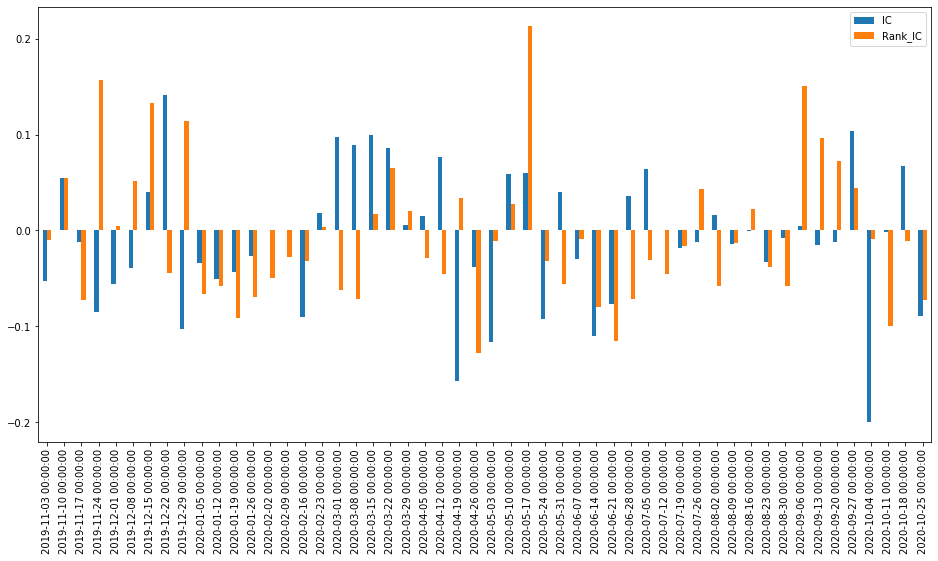

In [788]:
def Get_ICs(factor_name):
    IC_s = pd.DataFrame(0,index=HSreturns.index,columns=['IC', 'Rank_IC'])
    def _IC(return_list, factor_list):
        return np.corrcoef(return_list, factor_list)

    def _Rank_IC(return_list, factor_list):
        ordered_r = np.argsort(return_list)
        ordered_f = np.argsort(factor_list)
        return np.corrcoef(ordered_r, ordered_f)

    f = factors_weekly[factor_name].shift(1).fillna(0)

    for t in range(1, T):
        r = HSreturns.iloc[t,:].values
        f_ = f.iloc[t,:].values
        IC_s.iloc[t,0] = _IC(r, f_)[0,1]
        IC_s.iloc[t,1] = _Rank_IC(r, f_)[0,1]

    IC_s[-52:].plot(figsize = (16,8),kind='bar')

Get_ICs('book_to_price_ratio')

### 策略逻辑
每月末调仓，此处暂不考虑交易成本， 以各类机器学习算法的个股预测上涨概率(也就是label为+1对应的概率)作为打分值，选取排名前10%的股票构建均值方差组合。

In [678]:
backtest = pd.DataFrame()
backtest = pd.DataFrame(0,index=HSreturns.index,columns=['decision tree'])
#回测数据框初始化
MLmethods = ['decision tree', 'GradientBoosting', 'Adaboost','naive bayes','knn','ensemble'] 
f_name = ['momentum','EMA5','EMAC10','MAC5','MAC10', 'book_to_price_ratio']
weights = np.zeros(N)
for method in MLmethods:
    backtest[method] = 0
backtest['eq_portfolio'] = 0
print(backtest.head())
for i in range(len(MLmethods)):
    method = MLmethods[i]
    model = None
    select_ = [] #被选中的股票代码
    for t in range(train_length, T-1):
        if (t - train_length) % test_length == 0: #训练
            y_with_length = y_pred_labels.iloc[(t - train_length):t,:]
            X_data = factors_weekly[f_name[0]].iloc[(t - train_length):t,:].stack()
            #X_data.columns = f_name
            for i in range(1,len(f_name)):
                X_data = pd.concat([X_data,factors_weekly[f_name[i]].iloc[(t - train_length):t,:].stack()], axis = 1)
            y_data = y_with_length.stack()
            X_data.columns = f_name
            model = MLtrain(y_data, X_data,method = method)
            print(method,'train time ',t)
        if (t - train_length) % change_position_length == 0: #选股
            test_data_thisWeek= factors_weekly[f_name[0]].iloc[t,:]
            for i in range(1,len(f_name)):
                test_data_thisWeek = pd.concat([test_data_thisWeek,factors_weekly[f_name[i]].iloc[t,:]], axis = 1)
            test_data_thisWeek.columns = f_name 
            test_data_features = test_data_thisWeek.values
            test_data_thisWeek['predict_label'] = model.predict(test_data_features)
            test_data_thisWeek['predict_proba'] = model.predict_proba(test_data_features)[:,2]
            prob = test_data_thisWeek['predict_proba'] 
            x1 = (-prob).argsort(prob) #排序，选前10%
            select = prob[x1][:int(select_ratio*N)].index.to_list()
            select_ = list(set(select).intersection(set(stocks)))#由于部分股票的名称跟因子对应的名称不一致，因此取交集。
            data_r = HSreturns[select_].iloc[t-mean_variance_length:t,:]
            #print(data_r.shape)
            weights = min_variance(data_r) #调仓
            #print('weights: ', weights)
            #print('change position',t, ' stock seleted ', len(select_))
            backtest.iloc[t,i] = np.sum(weights * HSreturns[select_].iloc[t,:].values)
            #print(backtest.iloc[t, i])
            #backtest.iloc[t, 2] = np.mean(HSreturns.iloc[t,:].values)
        else:
        
            backtest.iloc[t,i] = np.sum(weights * HSreturns[select_].iloc[t,:].values)
            #backtest.iloc[t, 2] = np.mean(HSreturns.iloc[t,:].values)
    backtest[method] = backtest.iloc[:,i]
    print(backtest[method])
for t in range(train_length, T-1):
    backtest.iloc[t, 6] = np.mean(HSreturns.iloc[t,:].values)
    

            decision tree  GradientBoosting  Adaboost  naive bayes  knn  \
2010-01-10              0                 0         0            0    0   
2010-01-17              0                 0         0            0    0   
2010-01-24              0                 0         0            0    0   
2010-01-31              0                 0         0            0    0   
2010-02-07              0                 0         0            0    0   

            ensemble  eq_portfolio  
2010-01-10         0             0  
2010-01-17         0             0  
2010-01-24         0             0  
2010-01-31         0             0  
2010-02-07         0             0  
decision tree train time  104
decision tree train time  130
decision tree train time  156
decision tree train time  182
decision tree train time  208
decision tree train time  234
decision tree train time  260
decision tree train time  286
decision tree train time  312
decision tree train time  338
decision tree train time  3

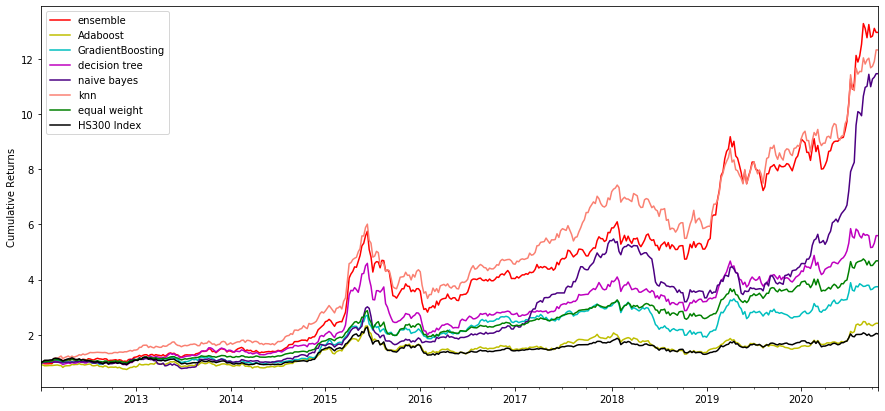

In [683]:
#for method in MLmethods:
#((backtest['ensemble2'][train_length:]+1).cumprod()).plot(figsize=(15,7),color='salmon')
plt.figure()
((backtest['ensemble'][train_length:]+1).cumprod()).plot(figsize=(15,7),color='r')
((backtest['Adaboost'][train_length:]+1).cumprod()).plot(figsize=(15,7),color='y')
((backtest['GradientBoosting'][train_length:]+1).cumprod()).plot(figsize=(15,7),color='c')
((backtest['decision tree'][train_length:]+1).cumprod()).plot(figsize=(15,7),color='m')
((backtest['naive bayes'][train_length:]+1).cumprod()).plot(figsize=(15,7),color='indigo')
#((backtest['logistic regression'][train_length:]+1).cumprod()-1).plot(figsize=(15,7),color='salmon')
((backtest['knn'][train_length:]+1).cumprod()).plot(figsize=(15,7),color='salmon')
((backtest['eq_portfolio'][train_length:]+1).cumprod()).plot(figsize=(15,7),color='g')
((HSIreturns['000300.XSHG'][train_length:]+1).cumprod()).plot(figsize=(15,7),color='black')
plt.ylabel('Cumulative Returns')
plt.legend(['ensemble', 'Adaboost','GradientBoosting','decision tree','naive bayes',\
            'knn','equal weight','HS300 Index'])
plt.show()

In [740]:
import statsmodels.api as sm
from statsmodels import regression
from prettytable import PrettyTable

def MaxDrawdown(return_list):
    a = np.maximum.accumulate(return_list)
    l = np.argmax((np.maximum.accumulate(return_list) - return_list) /np.maximum.accumulate(return_list))
    k = np.argmax(return_list[:l])
    return (return_list[k] - return_list[l])/(return_list[l])

def Performance(method = 'ensemble'):
    table = PrettyTable(['performance', 'value'])

    #max drawdown
    mdd = MaxDrawdown((backtest[method][train_length:]+1).cumprod())
    table.add_row(['MaxDrawdown', mdd.astype(np.float16)])
    #time horizon
    t = (backtest[method].index[T-1]-backtest[method].index[train_length]).days
    #annual return
    anul_return = (backtest[method][train_length:]+1).cumprod()[-1]**(1/t*255)-1
    #annual vol
    anul_vol = backtest[method].std()*(52**(1/2))
    #Sharpe Ratio
    spr = anul_return/anul_vol
    table.add_row(['Sharpe Ratio', spr.astype(np.float16)])
    #Sortino Ratio
    down_return = backtest[method][backtest[method]<0]
    anul_downvol = down_return.std()*(52**(1/2))
    sorr = anul_return/anul_downvol
    table.add_row(['Sortino Ratio', sorr.astype(np.float16)])
    #beta & alpha
    y = backtest[method].iloc[train_length:-1]
    x = HSIreturns['000300.XSHG'].iloc[train_length:-1]
    x = sm.add_constant(x)
    model = regression.linear_model.OLS(y,x).fit()
    beta = model.params[1]
    alpha = model.params[0]
    table.add_row(['beta', beta.astype(np.float16)])
    table.add_row(['alpha', alpha.astype(np.float16)])
    #IR
    cum_return = ((backtest[method][train_length:]+1).cumprod() - \
    (HSIreturns['000300.XSHG'][train_length:]+1).cumprod())[-1]**(1/t*255)
    alpha_ = backtest[method].iloc[train_length:] - HSIreturns['000300.XSHG'].iloc[train_length:]
    alpha_vol = alpha_.std()*(52**(1/2))
    ir = cum_return/alpha_vol
    table.add_row(['information rate', ir.astype(np.float16)])
    print(table.get_string(title=method))

In [741]:
for method in MLmethods:
    Performance(method)


+----------------------------+
|       decision tree        |
+------------------+---------+
|   performance    |  value  |
+------------------+---------+
|   MaxDrawdown    |  1.311  |
|   Sharpe Ratio   |  0.621  |
|  Sortino Ratio   |  0.8027 |
|       beta       |  0.913  |
|      alpha       | 0.00257 |
| information rate |   6.48  |
+------------------+---------+
+-----------------------------+
|       GradientBoosting      |
+------------------+----------+
|   performance    |  value   |
+------------------+----------+
|   MaxDrawdown    |  0.703   |
|   Sharpe Ratio   |  0.4907  |
|  Sortino Ratio   |  0.6777  |
|       beta       |  0.9077  |
|      alpha       | 0.001644 |
| information rate |   6.81   |
+------------------+----------+
+------------------------------+
|           Adaboost           |
+------------------+-----------+
|   performance    |   value   |
+------------------+-----------+
|   MaxDrawdown    |   0.7954  |
|   Sharpe Ratio   |   0.3213  |
|  Sortino Ra

In [789]:
df_mom2 = pd.read_csv('data2/momentum_extend.csv', index_col=0)

In [790]:
df_mom2.shape

(2621, 591)